# JSON To Text

### Pull the required data (Report_ID and PDF content) from a JSON file.

Translate the PDF and text file inside each report. And save it with the name report_ID.txt

In [1]:
import os
import json
import re

# Function to create an empty folder
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

# Function to extract PDF content and save as txt files
def save_pdf_contents_as_txt(json_folder, output_folder):
    # Create the output folder if it doesn't exist
    create_folder(output_folder)
    
    # Iterate through each JSON file in the folder
    for json_file in os.listdir(json_folder):
        if json_file.endswith('.json'):
            try:
                
                # Load the JSON data
                with open(os.path.join(json_folder, json_file), 'r', encoding='utf-8') as file:
                    data = json.load(file)
                
                # Extract the Report_ID
                report_id = data["Report_ID"]
                
                # Extract PDF contents and save as txt files
                pdf_contents = data.get("PDF", {})
                for key, content_list in pdf_contents.items():
                    # Combine all content in the list into a single string
                    combined_content = "\n".join(content_list)
                    
                    # Clear Unicode characters, keeping only hyphen (-) and em dash (–) characters
                    combined_content = re.sub(r'[^\x00-\x7F\u2013\u2014]+', '', combined_content)
                    
                    # Create the filename for the combined content
                    txt_filename = f"{report_id}_{key}.txt"
                    txt_filepath = os.path.join(output_folder, txt_filename)
                    
                    # Write the combined content to the txt file
                    with open(txt_filepath, 'w', encoding='utf-8') as txt_file:
                        txt_file.write(combined_content)
            
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in file {json_file}: {e}")

# Define the folder paths
json_folder = "flattened_jsons"  # Replace with the path to your JSON folder

# Create the folder to save txt files
create_folder("reports")

# Call the function to process the JSON files
save_pdf_contents_as_txt(json_folder, "reports")


#### Nots:
 **Unicode Cleanup**:
   ```python
  combined_content = re.sub(r'[^\x00-\x7F\u2013\u2014]+', '', combined_content)
   ```
   This line strips all characters in `pdf_content` except ASCII characters (U+0000-U+007F) and two special Unicode characters (U+2013 em dash and U+2014 em dash). Thus, only these characters are left in the text and other Unicode characters are removed in the `NER Annotation Tool` to avoid causing character shifting.

# Find Reports with GRI Table to make NER Annotation

In [4]:
import os
import re

folder_path = "reports"  # Folder path consisting of report txt files

# Define a list of keywords and patterns to search for
keywords = [
    "GRI", "GRI Index", "GRI Content", "G4", "G4 Index", "G4 Content",  # Keywords related to GRI Tables
    r"EC\d{1,2}", r"EN\d{1,2}", r"LA\d{1,2}", r"HR\d{1,2}", r"SO\d{1,2}", r"PR\d{1,2}", r"EU\d{1,2}", r"DMA",  # Patterns for EC2, EN6, LA9, etc.
    r"1\.\s?\d+", r"2\.\s?\d+", r"3\.\s?\d+", r"4\.\s?\d+",  # Patterns for numbered lists (1.1, 2.5, etc.)
    r"GRI\s102-\d+", r"GRI\s\d+-\d+",  # Patterns for GRI standards like "GRI 102-3"
    r"\d{3}-\d{1,2}",  # Pattern for matching "102-1", "102-5", "102-15", etc.
    r"G4-\d{1,2}"  # Pattern for matching "G4-1", "G4-3", "G4-16", etc.
]

# Compile regular expressions for the patterns
compiled_patterns = [re.compile(pattern) for pattern in keywords]

# Initialize the list to store the reports with GRI table
reports_with_gri_table = []

# Get the list of files in the folder
files = os.listdir(folder_path)

# Loop through each file in the folder
for file in files:
    file_path = os.path.join(folder_path, file)  # Get the full path of the file

    with open(file_path, "r", encoding="utf-8") as f:  # Open the file using the full path
        file_content = f.read()
        
        # Check if any of the compiled patterns match the file content
        if any(pattern.search(file_content) for pattern in compiled_patterns):
            reports_with_gri_table.append(file)
            
reports_with_gri_table = sorted(reports_with_gri_table)  # Sort the list of reports

# Create a text file to save the list of reports_with_gri_table
output_file = "reports_with_gri_table_list.txt"

# Open the file in write mode
with open(output_file, "w") as f:
    # Write each report file name to a new line in the file
    for report in reports_with_gri_table:
        f.write(report + "\n")


# NER Annotation with Text

* Label the text in each {report_id}_{key}.txt with [NER annotation tool](https://tecoholic.github.io/ner-annotator/)

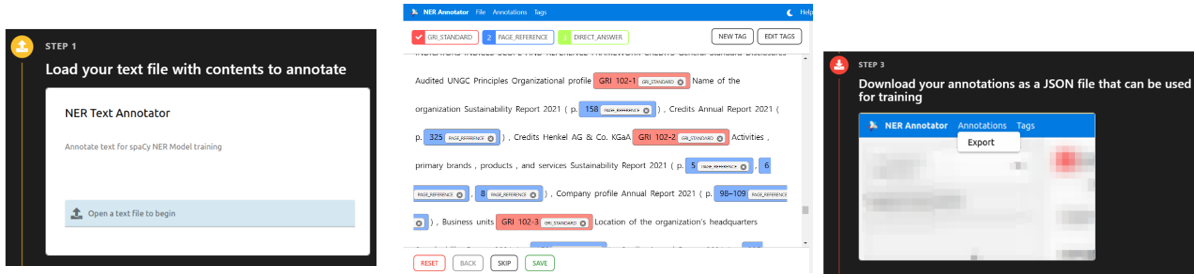

# Text To JSON

* tagged text is saved as annotations.json. **manually** the name is converted to {report_id}_{key}_annotations.json .

* An empty folder named reports_annotations opens. And all {report_id}_{key}_annotations.json files saved in this folder.

# Let's visualize the labels with spacy – displacy

In [ ]:
import spacy
from spacy import displacy

# Install the English model of Spacy
nlp = spacy.load("en_core_web_sm")

# Sample text
text = "Apple is looking at buying U.K. startup for $1 billion"

# Process text
doc = nlp(text)

# NER visualization
displacy.render(doc, style="ent", jupyter=True)


In [ ]:
import json
import spacy
from spacy import displacy

# Load the Spacy model
nlp = spacy.load("en_core_web_sm")

# Specify the path to the JSON file
file_path = "reports_annotations/15469_2_annotations.json"

# Open the JSON file and load the data
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

    if 'annotations' in data:
        for annotation in data['annotations']:
            if annotation is not None:
                text = annotation[0]  
                entities = [(ent[0], ent[1], ent[2]) for ent in annotation[1]['entities']]  

                # Prepare the data in the required format for Displacy
                spacy_displacy_data = {
                    "text": text,
                    "ents": [{"start": start, "end": end, "label": label} for start, end, label in entities],
                    "title": None
                }

                # Visualize with Displacy
                displacy.render(spacy_displacy_data, style="ent", manual=True, jupyter=True)


# NER Model Steps

* The data set is created by pulling files named report.json (tagged PDF text files) in the folder named reports_annotations

# Create Dataset for NER model (with a JSON file)

In [1]:
import os
import json
import random

# Specify the folder path containing the JSON files with annotations
folder_path = 'reports_annotations'  

# DATA array (for TRAIN + EVAL)
DATA = []

# Read all JSON files in folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            if 'annotations' in data:
                for annotation in data['annotations']:
                    if annotation is not None:
                        text = annotation[0]
                        entities = [(ent[0], ent[1], ent[2]) for ent in annotation[1]['entities']]
                        DATA.append((text, {'entities': entities}))

# Function to clean entities
def clean_entities(text, entities):
    cleaned_entities = []
    for start, end, label in entities:
        # Remove leading and trailing whitespace from the entity span
        while start < len(text) and text[start].isspace():
            start += 1
        while end > 0 and text[end - 1].isspace():
            end -= 1
        if start < end:  # Ensure the span is valid
            cleaned_entities.append((start, end, label))
    return cleaned_entities

# Clean your data
cleaned_data = []
for text, annotations in DATA:
    entities = clean_entities(text, annotations['entities'])
    if entities:  # Only add if there are valid entities
        cleaned_data.append((text, {'entities': entities}))

# shuffle data
random.shuffle(cleaned_data)

# Split the data into 80% Train, 20% Eval
train_size = int(0.8 * len(cleaned_data))
TRAIN_DATA = cleaned_data[:train_size]
EVAL_DATA = cleaned_data[train_size:]

print("Training Data:", len(TRAIN_DATA))
print("Evaluation Data:", len(EVAL_DATA))

Training Data: 32
Evaluation Data: 8


### Let's observe Training Data and Evaluation Data as Dataframe

In [3]:
%pip install pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.6 MB 6.7 MB/s eta 0:00:02
   ---------- ----------------------------- 3.1/11.6 MB 6.4 MB/s eta 0:00:02
   -------------- ------------------------- 4.2/11.6 MB 6.3 MB/s eta 0:00:02
   ------------------ --------------------- 5.5/11.6 MB 6.2 MB/s eta 0:00:01
   ----------------------- ---------------- 6.8/11.6 MB 6.2 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.6 MB 6.2 MB/s eta 0:00:01
   ------------------------------- -------- 9.2/11.6 MB 6.1 MB/s eta 0:00:01
   ------------------------------------ --- 10.5/11.6 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# show train data as a df.

import pandas as pd

# Extract text and entities for the DataFrame
train_texts = [item[0] for item in TRAIN_DATA]
train_entities = [item[1]['entities'] for item in TRAIN_DATA]

# Create a DataFrame
df = pd.DataFrame({'Text': train_texts, 'Entities': train_entities})

# Display the DataFrame
df


,Text,Entities
0,integrated report 2017 This is TOTVS Integr...,"[(18493, 18499, GRI_STANDARD), (18504, 18510, ..."
1,Wipro Sustainability Report 2016 - ...,"[(423288, 423291, GRI_STANDARD), (423293, 4233..."
2,K-water 2010 Sustainability Report K-water 201...,"[(314926, 314929, GRI_STANDARD), (314983, 3149..."
3,Sustainability Report 2017 03 PRESENTATION ...,"[(196722, 196727, GRI_STANDARD), (196728, 1967..."
4,Corporate responsibility report 20 17 SAndr...,"[(123132, 123139, GRI_STANDARD), (123151, 1231..."
5,1 2011 United Nation Global C...,"[(4332, 4335, GRI_STANDARD), (4537, 4542, GRI_..."
6,Corporate Social Responsibility Report 2017 ...,"[(66620, 66623, GRI_STANDARD), (66663, 66665, ..."
7,GLOBAL CITIZENSHIP REPORT 2016 INTRODUCTIO...,"[(231544, 231548, GRI_STANDARD), (231598, 2316..."
8,Annual report 2017 1 January 2017 – 31 Decem...,"[(239790, 239793, GRI_STANDARD), (239795, 2397..."
9,CEO Message 04 About HIRA 06 Governance and Or...,"[(152155, 152159, GRI_STANDARD), (152219, 1522..."


In [5]:
# show evaluation data as a df.

import pandas as pd

# Extract text and entities for the DataFrame
eval_texts = [item[0] for item in EVAL_DATA]
eval_entities = [item[1]['entities'] for item in EVAL_DATA]

# Create a DataFrame
df = pd.DataFrame({'Text': eval_texts, 'Entities': eval_entities})

# Display the DataFrame
df


,Text,Entities
0,Ajinomoto Group Sustainability Data Book 2020 ...,"[(203857, 203865, GRI_STANDARD), (203866, 2038..."
1,2017 SUSTAINABILITY DATA 2 CASTELLUM SUSTA...,"[(345, 350, GRI_STANDARD), (368, 375, GRI_STAN..."
2,Akbank Sustainability Report 2019 Contents 0...,"[(282312, 282318, GRI_STANDARD), (282322, 2823..."
3,2009 Corporate Responsibility Report 2009 Cor...,"[(351704, 351707, GRI_STANDARD), (351734, 3517..."
4,Title Subtitle 1 Givaudan – 2017 Sustainabilit...,"[(169866, 169873, GRI_STANDARD), (169886, 1698..."
5,SUSTAINABILITY REPORT 2021 03 Foreword 04 ...,"[(359635, 359644, GRI_STANDARD), (359701, 3597..."
6,Dialog Semiconductor – Sustainability report 2...,"[(3478, 3482, GRI_STANDARD), (3747, 3748, PAGE..."
7,Old Mutual South Africa Sustainability Report...,"[(185423, 185426, GRI_STANDARD), (185595, 1855..."


# Create NER model

In [6]:
import os
import json
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from tqdm import tqdm

# Load the pre-trained model
nlp = spacy.blank("en")

# Add the NER pipeline
ner = nlp.add_pipe("ner")

# Add new entity labels
for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Disable other pipelines
pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# Begin training
with nlp.disable_pipes(*unaffected_pipes):
    optimizer = nlp.begin_training()
    for itn in tqdm(range(125)):  # Number of iterations
        losses = {}
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)]
            nlp.update(examples, drop=0.3, losses=losses)
        print(f"Iteration {itn}, Losses: {losses}")

# Save the model
nlp.to_disk("custom_ner_model")


  0%|          | 0/125 [00:00<?, ?it/s]c:\Users\tokel\OneDrive\Masaüstü\sill\.conda\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Annual  report 2017  1 January 2017 – 31 December ..." with entities "[(239790, 239793, 'GRI_STANDARD'), (239795, 239798...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
c:\Users\tokel\OneDrive\Masaüstü\sill\.conda\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "CEO Message 04 About HIRA 06 Governance and Organi..." with entities "[(152155, 152159, 'GRI_STANDARD'), (152219, 152222...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
c:\Users\tokel\OneDrive\Masaüstü\si

Iteration 0, Losses: {'ner': 948619.6829528809}


  2%|▏         | 2/125 [04:51<4:58:31, 145.62s/it]

Iteration 1, Losses: {'ner': 53401.101159546524}


  2%|▏         | 3/125 [07:37<5:15:10, 155.00s/it]

Iteration 2, Losses: {'ner': 15180.007533729076}


  3%|▎         | 4/125 [10:16<5:15:32, 156.47s/it]

Iteration 3, Losses: {'ner': 12187.404451310635}


  4%|▍         | 5/125 [12:52<5:12:17, 156.14s/it]

Iteration 4, Losses: {'ner': 9802.489415362477}


  5%|▍         | 6/125 [15:23<5:06:45, 154.67s/it]

Iteration 5, Losses: {'ner': 8864.120109461248}


  6%|▌         | 7/125 [17:53<5:01:06, 153.11s/it]

Iteration 6, Losses: {'ner': 11388.596679329872}


  6%|▋         | 8/125 [20:33<5:02:24, 155.08s/it]

Iteration 7, Losses: {'ner': 9718.214934587479}


  7%|▋         | 9/125 [23:15<5:04:31, 157.51s/it]

Iteration 8, Losses: {'ner': 8184.713896222413}


  8%|▊         | 10/125 [25:58<5:05:08, 159.21s/it]

Iteration 9, Losses: {'ner': 7266.424450237304}


  9%|▉         | 11/125 [28:28<4:57:01, 156.33s/it]

Iteration 10, Losses: {'ner': 6827.055796331493}


 10%|▉         | 12/125 [30:52<4:47:28, 152.64s/it]

Iteration 11, Losses: {'ner': 6572.282261475921}


 10%|█         | 13/125 [33:07<4:34:45, 147.20s/it]

Iteration 12, Losses: {'ner': 6154.922281038016}


 11%|█         | 14/125 [35:41<4:35:48, 149.09s/it]

Iteration 13, Losses: {'ner': 6775.945556342369}


 12%|█▏        | 15/125 [38:03<4:29:29, 146.99s/it]

Iteration 14, Losses: {'ner': 5936.218913732795}


 13%|█▎        | 16/125 [40:30<4:27:21, 147.17s/it]

Iteration 15, Losses: {'ner': 5375.489956186619}


 14%|█▎        | 17/125 [42:48<4:19:34, 144.21s/it]

Iteration 16, Losses: {'ner': 5234.599910544697}


 14%|█▍        | 18/125 [45:12<4:17:12, 144.23s/it]

Iteration 17, Losses: {'ner': 4989.601732420502}


 15%|█▌        | 19/125 [47:50<4:22:02, 148.33s/it]

Iteration 18, Losses: {'ner': 4645.506773310364}


 16%|█▌        | 20/125 [50:19<4:19:49, 148.47s/it]

Iteration 19, Losses: {'ner': 4447.033350543119}


 17%|█▋        | 21/125 [52:45<4:16:19, 147.88s/it]

Iteration 20, Losses: {'ner': 4505.03190470126}


 18%|█▊        | 22/125 [55:05<4:09:32, 145.36s/it]

Iteration 21, Losses: {'ner': 4272.902167743654}


 18%|█▊        | 23/125 [57:36<4:10:10, 147.16s/it]

Iteration 22, Losses: {'ner': 4208.58118310757}


 19%|█▉        | 24/125 [1:00:03<4:07:30, 147.03s/it]

Iteration 23, Losses: {'ner': 4232.618033307503}


 20%|██        | 25/125 [1:02:20<4:00:17, 144.17s/it]

Iteration 24, Losses: {'ner': 4220.8862564256415}


 21%|██        | 26/125 [1:04:39<3:55:10, 142.53s/it]

Iteration 25, Losses: {'ner': 3776.984046539874}


 22%|██▏       | 27/125 [1:07:00<3:52:14, 142.18s/it]

Iteration 26, Losses: {'ner': 4008.2774644589517}


 22%|██▏       | 28/125 [1:09:19<3:48:01, 141.05s/it]

Iteration 27, Losses: {'ner': 3605.0522125132266}


 23%|██▎       | 29/125 [1:11:45<3:48:12, 142.63s/it]

Iteration 28, Losses: {'ner': 3867.1741606921423}


 24%|██▍       | 30/125 [1:14:10<3:47:03, 143.40s/it]

Iteration 29, Losses: {'ner': 3562.9316587424255}


 25%|██▍       | 31/125 [1:16:48<3:51:30, 147.77s/it]

Iteration 30, Losses: {'ner': 3840.9639099952765}


 26%|██▌       | 32/125 [1:19:12<3:47:26, 146.74s/it]

Iteration 31, Losses: {'ner': 3601.5283763280604}


 26%|██▋       | 33/125 [1:21:38<3:44:12, 146.23s/it]

Iteration 32, Losses: {'ner': 3479.6015731855296}


 27%|██▋       | 34/125 [1:24:01<3:40:27, 145.36s/it]

Iteration 33, Losses: {'ner': 3574.2923571858555}


 28%|██▊       | 35/125 [1:26:27<3:38:23, 145.60s/it]

Iteration 34, Losses: {'ner': 3236.7149331509136}


 29%|██▉       | 36/125 [1:29:02<3:40:03, 148.35s/it]

Iteration 35, Losses: {'ner': 3661.7512161467457}


 30%|██▉       | 37/125 [1:31:18<3:32:03, 144.59s/it]

Iteration 36, Losses: {'ner': 3109.3621237474727}


 30%|███       | 38/125 [1:33:48<3:32:10, 146.33s/it]

Iteration 37, Losses: {'ner': 3296.633127092384}


 31%|███       | 39/125 [1:36:23<3:33:21, 148.85s/it]

Iteration 38, Losses: {'ner': 3162.6776671070256}


 32%|███▏      | 40/125 [1:38:34<3:23:31, 143.66s/it]

Iteration 39, Losses: {'ner': 3115.1302481721214}


 33%|███▎      | 41/125 [1:40:53<3:19:14, 142.32s/it]

Iteration 40, Losses: {'ner': 3055.4697175745387}


 34%|███▎      | 42/125 [1:43:24<3:20:13, 144.75s/it]

Iteration 41, Losses: {'ner': 3060.507425086922}


 34%|███▍      | 43/125 [1:45:45<3:16:31, 143.80s/it]

Iteration 42, Losses: {'ner': 2862.605517320335}


 35%|███▌      | 44/125 [1:48:08<3:13:49, 143.57s/it]

Iteration 43, Losses: {'ner': 2837.175609844897}


 36%|███▌      | 45/125 [1:50:40<3:14:36, 145.96s/it]

Iteration 44, Losses: {'ner': 2907.300037787063}


 37%|███▋      | 46/125 [1:53:07<3:12:31, 146.23s/it]

Iteration 45, Losses: {'ner': 2812.0106090107}


 38%|███▊      | 47/125 [1:55:49<3:16:10, 150.91s/it]

Iteration 46, Losses: {'ner': 2863.5940669463016}


 38%|███▊      | 48/125 [1:58:28<3:17:00, 153.51s/it]

Iteration 47, Losses: {'ner': 2824.229729246348}


 39%|███▉      | 49/125 [2:01:01<3:14:04, 153.22s/it]

Iteration 48, Losses: {'ner': 2769.5022447626106}


 40%|████      | 50/125 [2:03:27<3:08:52, 151.10s/it]

Iteration 49, Losses: {'ner': 2734.623851640732}


 41%|████      | 51/125 [2:05:54<3:04:42, 149.76s/it]

Iteration 50, Losses: {'ner': 2634.9321935038897}


 42%|████▏     | 52/125 [2:08:30<3:04:31, 151.66s/it]

Iteration 51, Losses: {'ner': 2802.167621378205}


 42%|████▏     | 53/125 [2:10:59<3:01:02, 150.86s/it]

Iteration 52, Losses: {'ner': 2680.1449891270604}


 43%|████▎     | 54/125 [2:13:20<2:55:02, 147.92s/it]

Iteration 53, Losses: {'ner': 2728.743058823922}


 44%|████▍     | 55/125 [2:15:48<2:52:50, 148.15s/it]

Iteration 54, Losses: {'ner': 2608.152866154094}


 45%|████▍     | 56/125 [2:18:16<2:50:06, 147.91s/it]

Iteration 55, Losses: {'ner': 2643.106404056307}


 46%|████▌     | 57/125 [2:20:44<2:47:43, 147.99s/it]

Iteration 56, Losses: {'ner': 2529.350949528045}


 46%|████▋     | 58/125 [2:23:11<2:45:05, 147.85s/it]

Iteration 57, Losses: {'ner': 2456.514003586606}


 47%|████▋     | 59/125 [2:25:34<2:40:57, 146.32s/it]

Iteration 58, Losses: {'ner': 2430.1337640241254}


 48%|████▊     | 60/125 [2:28:03<2:39:17, 147.04s/it]

Iteration 59, Losses: {'ner': 2546.5352530071577}


 49%|████▉     | 61/125 [2:30:34<2:38:08, 148.25s/it]

Iteration 60, Losses: {'ner': 2506.0490376734815}


 50%|████▉     | 62/125 [2:33:06<2:36:55, 149.46s/it]

Iteration 61, Losses: {'ner': 2422.5469757343817}


 50%|█████     | 63/125 [2:35:37<2:34:57, 149.96s/it]

Iteration 62, Losses: {'ner': 2388.752993889604}


 51%|█████     | 64/125 [2:38:14<2:34:32, 152.00s/it]

Iteration 63, Losses: {'ner': 2264.4310803457047}


 52%|█████▏    | 65/125 [2:40:34<2:28:12, 148.20s/it]

Iteration 64, Losses: {'ner': 2370.2245526266997}


 53%|█████▎    | 66/125 [2:42:54<2:23:20, 145.77s/it]

Iteration 65, Losses: {'ner': 2259.4370998690138}


 54%|█████▎    | 67/125 [2:45:30<2:24:02, 149.01s/it]

Iteration 66, Losses: {'ner': 2222.2146806335077}


 54%|█████▍    | 68/125 [2:47:48<2:18:19, 145.60s/it]

Iteration 67, Losses: {'ner': 2310.4312378557606}


 55%|█████▌    | 69/125 [2:50:15<2:16:12, 145.94s/it]

Iteration 68, Losses: {'ner': 2219.3899213845543}


 56%|█████▌    | 70/125 [2:52:40<2:13:45, 145.92s/it]

Iteration 69, Losses: {'ner': 2319.879170022905}


 57%|█████▋    | 71/125 [2:55:03<2:10:22, 144.85s/it]

Iteration 70, Losses: {'ner': 2242.9418775874365}


 58%|█████▊    | 72/125 [2:57:24<2:07:03, 143.83s/it]

Iteration 71, Losses: {'ner': 2223.0274521504743}


 58%|█████▊    | 73/125 [2:59:52<2:05:38, 144.96s/it]

Iteration 72, Losses: {'ner': 2327.973867860099}


 59%|█████▉    | 74/125 [3:02:09<2:01:11, 142.58s/it]

Iteration 73, Losses: {'ner': 2169.5079883206054}


 60%|██████    | 75/125 [3:04:27<1:57:35, 141.12s/it]

Iteration 74, Losses: {'ner': 2231.6826206624246}


 61%|██████    | 76/125 [3:06:56<1:57:16, 143.59s/it]

Iteration 75, Losses: {'ner': 2172.3274043587153}


 62%|██████▏   | 77/125 [3:09:14<1:53:39, 142.07s/it]

Iteration 76, Losses: {'ner': 2089.039128958342}


 62%|██████▏   | 78/125 [3:11:29<1:49:26, 139.71s/it]

Iteration 77, Losses: {'ner': 2019.5834826333048}


 63%|██████▎   | 79/125 [3:13:55<1:48:40, 141.76s/it]

Iteration 78, Losses: {'ner': 2143.8281137287504}


 64%|██████▍   | 80/125 [3:16:17<1:46:25, 141.91s/it]

Iteration 79, Losses: {'ner': 2110.2684677961515}


 65%|██████▍   | 81/125 [3:18:48<1:45:57, 144.49s/it]

Iteration 80, Losses: {'ner': 2090.5246398556337}


 66%|██████▌   | 82/125 [3:21:16<1:44:20, 145.59s/it]

Iteration 81, Losses: {'ner': 2098.605301550764}


 66%|██████▋   | 83/125 [3:23:49<1:43:27, 147.79s/it]

Iteration 82, Losses: {'ner': 2065.5417822285963}


 67%|██████▋   | 84/125 [3:26:09<1:39:28, 145.57s/it]

Iteration 83, Losses: {'ner': 2020.6217205615853}


 68%|██████▊   | 85/125 [3:28:29<1:35:54, 143.87s/it]

Iteration 84, Losses: {'ner': 2059.394932182113}


 69%|██████▉   | 86/125 [3:30:54<1:33:35, 143.99s/it]

Iteration 85, Losses: {'ner': 1950.2454746399599}


 70%|██████▉   | 87/125 [3:33:20<1:31:33, 144.55s/it]

Iteration 86, Losses: {'ner': 1962.910821915848}


 70%|███████   | 88/125 [3:35:38<1:28:00, 142.73s/it]

Iteration 87, Losses: {'ner': 1994.1538436968149}


 71%|███████   | 89/125 [3:38:14<1:28:06, 146.84s/it]

Iteration 88, Losses: {'ner': 1858.0409481811657}


 72%|███████▏  | 90/125 [3:40:47<1:26:43, 148.66s/it]

Iteration 89, Losses: {'ner': 1923.7533742614905}


 73%|███████▎  | 91/125 [3:43:09<1:22:58, 146.41s/it]

Iteration 90, Losses: {'ner': 1928.5179716353377}


 74%|███████▎  | 92/125 [3:45:50<1:23:04, 151.05s/it]

Iteration 91, Losses: {'ner': 1934.6700504971668}


 74%|███████▍  | 93/125 [3:48:30<1:21:55, 153.60s/it]

Iteration 92, Losses: {'ner': 1919.0135260488241}


 75%|███████▌  | 94/125 [3:50:48<1:16:54, 148.86s/it]

Iteration 93, Losses: {'ner': 1912.9937541903637}


 76%|███████▌  | 95/125 [3:53:16<1:14:17, 148.59s/it]

Iteration 94, Losses: {'ner': 1871.6718949748902}


 77%|███████▋  | 96/125 [3:55:53<1:13:04, 151.20s/it]

Iteration 95, Losses: {'ner': 1851.7501221090206}


 78%|███████▊  | 97/125 [3:58:12<1:08:51, 147.54s/it]

Iteration 96, Losses: {'ner': 1911.5056245445448}


 78%|███████▊  | 98/125 [4:00:44<1:06:56, 148.75s/it]

Iteration 97, Losses: {'ner': 1780.7423421248786}


 79%|███████▉  | 99/125 [4:02:59<1:02:47, 144.89s/it]

Iteration 98, Losses: {'ner': 1877.702363502318}


 80%|████████  | 100/125 [4:05:25<1:00:28, 145.15s/it]

Iteration 99, Losses: {'ner': 1733.6027180990495}


 81%|████████  | 101/125 [4:07:47<57:42, 144.26s/it]  

Iteration 100, Losses: {'ner': 1763.2490054772352}


 82%|████████▏ | 102/125 [4:10:12<55:23, 144.50s/it]

Iteration 101, Losses: {'ner': 1872.0431599874355}


 82%|████████▏ | 103/125 [4:12:41<53:22, 145.57s/it]

Iteration 102, Losses: {'ner': 1804.719278174407}


 83%|████████▎ | 104/125 [4:15:12<51:33, 147.33s/it]

Iteration 103, Losses: {'ner': 1687.2059887504947}


 84%|████████▍ | 105/125 [4:17:37<48:54, 146.74s/it]

Iteration 104, Losses: {'ner': 1789.816906587741}


 85%|████████▍ | 106/125 [4:20:16<47:33, 150.21s/it]

Iteration 105, Losses: {'ner': 1735.7224372553028}


 86%|████████▌ | 107/125 [4:22:38<44:24, 148.01s/it]

Iteration 106, Losses: {'ner': 1724.7383127796165}


 86%|████████▋ | 108/125 [4:25:20<43:05, 152.06s/it]

Iteration 107, Losses: {'ner': 1687.9753194122004}


 87%|████████▋ | 109/125 [4:27:45<39:58, 149.88s/it]

Iteration 108, Losses: {'ner': 1666.9231444606376}


 88%|████████▊ | 110/125 [4:30:08<36:59, 148.00s/it]

Iteration 109, Losses: {'ner': 1762.6333472615515}


 89%|████████▉ | 111/125 [4:32:45<35:10, 150.72s/it]

Iteration 110, Losses: {'ner': 1765.5566926689062}


 90%|████████▉ | 112/125 [4:35:09<32:12, 148.66s/it]

Iteration 111, Losses: {'ner': 1685.302726332342}


 90%|█████████ | 113/125 [4:37:36<29:37, 148.14s/it]

Iteration 112, Losses: {'ner': 1681.4734317320836}


 91%|█████████ | 114/125 [4:39:52<26:29, 144.54s/it]

Iteration 113, Losses: {'ner': 1695.3492792046964}


 92%|█████████▏| 115/125 [4:42:22<24:19, 145.94s/it]

Iteration 114, Losses: {'ner': 1752.8383049466938}


 93%|█████████▎| 116/125 [4:44:43<21:41, 144.56s/it]

Iteration 115, Losses: {'ner': 1584.0966706852778}


 94%|█████████▎| 117/125 [4:47:05<19:09, 143.74s/it]

Iteration 116, Losses: {'ner': 1865.1536684210587}


 94%|█████████▍| 118/125 [4:49:28<16:44, 143.45s/it]

Iteration 117, Losses: {'ner': 1570.9761892679307}


 95%|█████████▌| 119/125 [4:51:56<14:29, 144.88s/it]

Iteration 118, Losses: {'ner': 1643.4479413270385}


 96%|█████████▌| 120/125 [4:54:19<12:01, 144.36s/it]

Iteration 119, Losses: {'ner': 1623.7558383267085}


 97%|█████████▋| 121/125 [4:56:42<09:35, 143.86s/it]

Iteration 120, Losses: {'ner': 1690.9053331285152}


 98%|█████████▊| 122/125 [4:59:11<07:16, 145.61s/it]

Iteration 121, Losses: {'ner': 1681.445282016959}


 98%|█████████▊| 123/125 [5:01:36<04:50, 145.40s/it]

Iteration 122, Losses: {'ner': 1628.0310733608658}


 99%|█████████▉| 124/125 [5:03:58<02:24, 144.40s/it]

Iteration 123, Losses: {'ner': 1628.898162843776}


100%|██████████| 125/125 [5:06:19<00:00, 147.03s/it]

Iteration 124, Losses: {'ner': 1567.1186690645509}


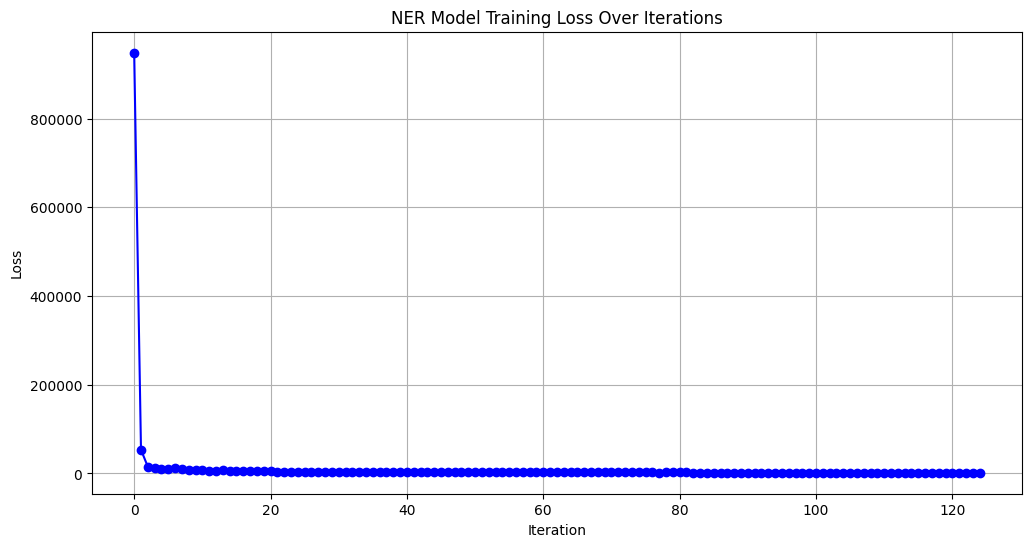

In [34]:
import matplotlib.pyplot as plt

# Data
iterations = list(range(125))
losses = [
    948619.6829528809, 53401.101159546524, 15180.007533729076, 12187.404451310635,
    9802.489415362477, 8864.120109461248, 11388.596679329872, 9718.214934587479,
    8184.713896222413, 7266.424450237304, 6827.055796331493, 6572.282261475921,
    6154.922281038016, 6775.945556342369, 5936.218913732795, 5375.489956186619,
    5234.599910544697, 4989.601732420502, 4645.506773310364, 4447.033350543119,
    4505.03190470126, 4272.902167743654, 4208.58118310757, 4232.618033307503,
    4220.8862564256415, 3776.984046539874, 4008.2774644589517, 3605.0522125132266,
    3867.1741606921423, 3562.9316587424255, 3840.9639099952765, 3601.5283763280604,
    3479.6015731855296, 3574.2923571858555, 3236.7149331509136, 3661.7512161467457,
    3109.3621237474727, 3296.633127092384, 3162.6776671070256, 3115.1302481721214,
    3055.4697175745387, 3060.507425086922, 2862.605517320335, 2837.175609844897,
    2907.300037787063, 2812.0106090107, 2863.5940669463016, 2824.229729246348,
    2769.5022447626106, 2734.623851640732, 2634.9321935038897, 2802.167621378205,
    2680.1449891270604, 2728.743058823922, 2608.152866154094, 2643.106404056307,
    2529.350949528045, 2456.514003586606, 2430.1337640241254, 2546.5352530071577,
    2506.0490376734815, 2422.5469757343817, 2388.752993889604, 2264.4310803457047,
    2370.2245526266997, 2259.4370998690138, 2222.2146806335077, 2310.4312378557606,
    2219.3899213845543, 2319.879170022905, 2242.9418775874365, 2223.0274521504743,
    2327.973867860099, 2169.5079883206054, 2231.6826206624246, 2172.3274043587153,
    2089.039128958342, 2019.5834826333048, 2143.8281137287504, 2110.2684677961515,
    2090.5246398556337, 2098.605301550764, 2065.5417822285963, 2020.6217205615853,
    2059.394932182113, 1950.2454746399599, 1962.910821915848, 1994.1538436968149,
    1858.0409481811657, 1923.7533742614905, 1928.5179716353377, 1934.6700504971668,
    1919.0135260488241, 1912.9937541903637, 1871.6718949748902, 1851.7501221090206,
    1911.5056245445448, 1780.7423421248786, 1877.702363502318, 1733.6027180990495,
    1763.2490054772352, 1872.0431599874355, 1804.719278174407, 1687.2059887504947,
    1789.816906587741, 1735.7224372553028, 1724.7383127796165, 1687.9753194122004,
    1666.9231444606376, 1762.6333472615515, 1765.5566926689062, 1685.302726332342,
    1681.4734317320836, 1695.3492792046964, 1752.8383049466938, 1584.0966706852778,
    1865.1536684210587, 1570.9761892679307, 1643.4479413270385, 1623.7558383267085,
    1690.9053331285152, 1681.445282016959, 1628.0310733608658, 1628.898162843776,
    1567.1186690645509
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(iterations, losses, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('NER Model Training Loss Over Iterations')
plt.grid(True)
plt.show()


The `loss` value in the model measures the difference between the outputs predicted by the model and the actual labels. The larger this difference, the greater the `loss` value. The `loss` value indicates the model's error, or how incorrectly it predicts. Therefore, as the 'loss' value decreases during training, it is understood that the model learns better and its predictions are more accurate.

## Various strategies to reduce the loss value during training of the model:

### 1. **Add More Training Data:**
   - **Data Quantity:** Adding more training data can improve the overall performance of the model. Insufficient data can lead to overfitting or underfitting.
   - **Data Diversity:** Diversify your training data. Adding more examples of the same entity types in different contexts and variations can enhance the model's general performance.

### 2. **Reduce Dropout Rate:**
   - The dropout rate (`drop=0.5`) is currently set at 50%. Reducing this rate may allow the model to retain more information. For example, you can change it to `drop=0.3`:
     ```python
     nlp.update(examples, drop=0.3, losses=losses)
     ```

### 3. **Increase the Number of Training Epochs:**
   - You're training for 100 iterations. If your loss value is consistently decreasing, you might consider increasing the number of iterations. However, be cautious as too many iterations can lead to overfitting.

### 4. **Adjust Optimizer Parameters:**
   - You can fine-tune the optimizer initiated with `begin_training()`. For example, adjusting the learning rate could be beneficial. You can add a specific learning rate parameter to the `begin_training()` method:
     ```python
     optimizer = nlp.begin_training(learn_rate=0.001)
     ```

### 5. **Adjust Minibatch Sizes:**
   - Minibatch sizes can be increased or kept constant (e.g., from 4.0 to 32.0). Smaller minibatch sizes may lead to more frequent updates in each iteration, which could improve the learning process:
     ```python
     batches = minibatch(TRAIN_DATA, size=4)
     ```

### 6. **Use Data Augmentation:**
   - To diversify training data, you can use data augmentation techniques. For example, creating different variations by altering words or sentence structures in the training data can be effective.

### 7. **Re-enable Other Pipelines:**
   - If you believe other pipelines besides `ner` could be beneficial, you can re-enable them instead of disabling them. This might help the model learn in a broader context.

By trying one or more of these strategies, you may be able to reduce your model's loss value and improve its overall performance.


## Test NER Model

In [7]:
import os
import spacy

nlp = spacy.load("custom_ner_model")

sample_report_path = "reports/10701_2.txt"

with open(sample_report_path, "r") as f:
    sample_text = f.read()

doc = nlp(sample_text)
for ent in doc.ents:
    print(ent.text, ent.label_)


2.1 GRI_STANDARD
2.4 GRI_STANDARD
2.6 GRI_STANDARD
2.7 GRI_STANDARD
2.9 GRI_STANDARD
2.10 GRI_STANDARD
3.1 GRI_STANDARD
3.4 GRI_STANDARD
3.7 GRI_STANDARD
3.8 GRI_STANDARD
3.10 GRI_STANDARD
3.11 GRI_STANDARD
3.12 GRI_STANDARD
4.1 GRI_STANDARD
4.2 GRI_STANDARD
4.3 GRI_STANDARD
4.4 GRI_STANDARD
4.6 GRI_STANDARD
4.7 GRI_STANDARD
4.8 GRI_STANDARD
4.9 GRI_STANDARD
4.10 GRI_STANDARD
4.11 GRI_STANDARD
4.12 GRI_STANDARD
4.13 GRI_STANDARD
4.14 GRI_STANDARD
4.15 GRI_STANDARD
4.16 GRI_STANDARD
4.17 GRI_STANDARD
9 PAGE_REFERENCE
32 PAGE_REFERENCE
EC4 GRI_STANDARD
EC5 GRI_STANDARD
EC7 GRI_STANDARD
EC8 GRI_STANDARD
EC9 GRI_STANDARD
EN4 GRI_STANDARD
98 PAGE_REFERENCE
EN6 GRI_STANDARD
EN7 GRI_STANDARD
98 PAGE_REFERENCE
EN10 GRI_STANDARD
EN11 GRI_STANDARD
EN12 GRI_STANDARD
EN13 GRI_STANDARD
EN15 GRI_STANDARD
EN16 GRI_STANDARD
EN17 GRI_STANDARD
EN18 GRI_STANDARD
98 PAGE_REFERENCE
EN21 GRI_STANDARD
98 PAGE_REFERENCE
EN23 GRI_STANDARD
EN26 GRI_STANDARD
EN27 GRI_STANDARD
EN28 GRI_STANDARD
EN29 GRI_STANDARD


# Evaluation of NER model

In [11]:
!pip install matplotlib
!pip install seaborn

  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\tokel\OneDrive\Masaüstü\sill\.conda\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Ajinomoto Group Sustainability Data Book 2020  Aji..." with entities "[(203857, 203865, 'GRI_STANDARD'), (203866, 203874...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]c:\Users\tokel\OneDrive\Masaüstü\sill\.conda\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "2017 SUSTAINABILITY DATA  2    CASTELLUM SUSTAINAB..." with entities "[(345, 350, 'GRI_STANDARD'), (368, 375, 'GRI_STAND...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warning

Overall Evaluation Scores:
{'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.6237201365187713, 'ents_r': 0.36098765432098767, 'ents_f': 0.45730372223959964, 'ents_per_type': {'GRI_STANDARD': {'p': 0.6781437125748503, 'r': 0.4281663516068053, 'f': 0.5249130938586326}, 'PAGE_REFERENCE': {'p': 0.5965665236051502, 'r': 0.2883817427385892, 'f': 0.38881118881118876}, 'DIRECT_ANSWER': {'p': 0.0, 'r': 0.0, 'f': 0.0}}, 'speed': 33138.051471381266}

Entity-level Evaluation Scores:
GRI_STANDARD: {'p': 0.6781437125748503, 'r': 0.4281663516068053, 'f': 0.5249130938586326}
PAGE_REFERENCE: {'p': 0.5965665236051502, 'r': 0.2883817427385892, 'f': 0.38881118881118876}
DIRECT_ANSWER: {'p': 0.0, 'r': 0.0, 'f': 0.0}


<Figure size 1200x600 with 0 Axes>

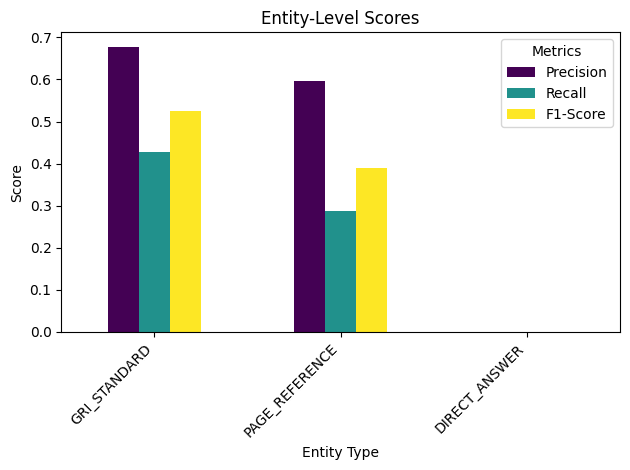

In [12]:
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from spacy.scorer import Scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Set the maximum length for text processing
nlp.max_length = 2000000  # 2 milyon karaktere kadar artırabilirsiniz

# Function to evaluate the model
def evaluate_model(nlp, eval_data):
    scorer = Scorer()
    examples = []
    for text, annotations in tqdm(eval_data):
        example = Example.from_dict(nlp.make_doc(text), annotations)
        examples.append(example)

    scores = nlp.evaluate(examples)
    return scores

# Function to visualize entity-level scores
def plot_entity_scores(scores):
    # Prepare data for plotting
    ent_types = list(scores["ents_per_type"].keys())
    precision = [scores["ents_per_type"][ent]["p"] for ent in ent_types]
    recall = [scores["ents_per_type"][ent]["r"] for ent in ent_types]
    f1 = [scores["ents_per_type"][ent]["f"] for ent in ent_types]

    df_scores = pd.DataFrame({
        'Entity Type': ent_types,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    # Plot
    plt.figure(figsize=(12, 6))
    df_scores.set_index('Entity Type').plot(kind='bar', colormap='viridis')
    plt.title('Entity-Level Scores')
    plt.xlabel('Entity Type')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metrics')
    plt.tight_layout()
    plt.show()

# Evaluate the model
scores = evaluate_model(nlp, EVAL_DATA)

# Print evaluation scores
print("Overall Evaluation Scores:")
print(scores)

# Print detailed entity-level scores
print("\nEntity-level Evaluation Scores:")
for ent_type, ent_scores in scores["ents_per_type"].items():
    print(f"{ent_type}: {ent_scores}")

# Plot entity-level scores
plot_entity_scores(scores)


### Overall Evaluation Scores:
- **token_acc**: Tokenization accuracy. A score of 1.0 indicates perfect tokenization.
- **token_p**: Tokenization precision. A score of 1.0 indicates perfect precision.
- **token_r**: Tokenization recall. A score of 1.0 indicates perfect recall.
- **token_f**: Tokenization F1 score. A score of 1.0 indicates a perfect F1 score.
- **ents_p**: Overall precision for entity recognition. A score of 0.5 indicates that 50% of the entities predicted by the model are correct.
- **ents_r**: Overall recall for entity recognition. A score of 1.0 indicates that the model correctly recognized all entities.
- **ents_f**: Overall F1 score for entity recognition. A score of 0.666 indicates a balance between precision and recall.
- **ents_per_type**: Detailed scores for each entity type.

### Entity-level Evaluation Scores:
- **gri_standard**:
  - **p** (precision): 1.0 - The model correctly identified all instances of the `gri_standard` entity type.
  - **r** (recall): 1.0 - The model found all `gri_standard` entities in the evaluation data.
  - **f** (F1 score): 1.0 - The F1 score combines precision and recall into a single metric, and a score of 1.0 indicates perfect performance for this entity type.
- **page_reference**:
  - **p** (precision): 0.0 - The model failed to correctly identify any instances of the `page_reference` entity type.
  - **r** (recall): 0.0 - The model did not find any `page_reference` entities in the evaluation data.
  - **f** (F1 score): 0.0 - The F1 score indicates very poor performance for this entity type.


## Evaluation results evaluation and improvement suggestions:

The model is working, but the results are not ideal. The low overall `ents_f` score (0.2358) indicates that the model is struggling to identify the GRI_STANDARD and PAGE_REFERENCE labels effectively.

### Detailed Results:
- **GRI_STANDARD**:
  - Precision: 0.5714 (High ratio of correct positive predictions)
  - Recall: 0.0426 (Only a small fraction of the correct labels were found)
  - F1-Score: 0.0792 (Low overall performance)
- **PAGE_REFERENCE**:
  - Precision: 0.4182 (Lower ratio of correct positive predictions)
  - Recall: 0.2160 (Approximately 22% of the correct labels were found)
  - F1-Score: 0.2848 (Slightly better overall performance but still low)

### Recommendations:
1. **Data Cleaning and Expansion**: Your data may need further cleaning or enrichment. Increasing the size of your labeled dataset and adding more examples could improve performance.
   
2. **More Training**: Training the model for more iterations, experimenting with different training strategies, or reducing the `dropout` rate could also be beneficial.

3. **Changes in Network Architecture**: Using a different Spacy model (e.g., starting with a pre-trained model) or adjusting the parameters of the `compounding` function (e.g., `size=compounding(4.0, 64.0, 1.001)`) might improve performance.

4. **Data Augmentation**: You can expand your training dataset using data augmentation techniques. For example, adding small text variations or randomizing label placements can enhance your model's overall performance.

After trying these steps, you can reassess your results and observe the progress. These types of fine-tuning are often necessary to improve the model's overall performance.

# Give unlabeled reports to the NER model

* Provide the path to the folder where each report's `pdf content` from a JSON file was previously saved as a `txt` file with the `report_ID` as the filename.

* Print the `report_ID` for each file.

* Pass the `pdf content` from each file to the NER model.

* Print the labeled data for each report.

* Save the `page_reference`, `direct_answer`, and `gri_standard` into a dictionary named `reports_dict` to use later.

## Don't run these cells

In [18]:
import os
import spacy
from tqdm import tqdm

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Set the maximum length for text processing
nlp.max_length = 2050000  # 2 milyon karaktere kadar artırabilirsiniz

folder_path = "reports_demo"  # give the folder path consisting of report txt files

# Get the list of files in the folder
files = os.listdir(folder_path)

# Initialize the dictionary to store data
reports_dict = {}

# Apply the NER model to reports in folder
for file in tqdm(files):
    file_path = os.path.join(folder_path, file)  # Get the full path of the file

    with open(file_path, "r", encoding="utf-8") as f:  # Open the file using the full path
        file_content = f.read()
        doc = nlp(file_content)

        # Temporary lists to store entities for the current report
        page_references = []
        direct_answers = []
        gri_standards = []

        for ent in doc.ents:
            if ent.label_ == 'PAGE_REFERENCE':
                page_references.append(ent.text)
            elif ent.label_ == 'DIRECT_ANSWER':
                direct_answers.append(ent.text)
            elif ent.label_ == 'GRI_STANDARD':
                gri_standards.append(ent.text)

        # Store the entities in the dictionary
        reports_dict[file] = {
            "page_references": page_references,
            "direct_answers": direct_answers,
            "gri_standards": gri_standards
        }

# Print the resulting dictionary
for report_id, content in reports_dict.items():
    print(f"Report ID: {report_id}")
    print(f"Page References: {content['page_references']}")
    print(f"Direct Answers: {content['direct_answers']}")
    print(f"GRI Standards: {content['gri_standards']}")
    print("-" * 50)


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

Report ID: 10203_1.txt
Page References: ['4-5', '4-5', '6,10-11', '10-11', '16-17', '68-71', '66-67', '8-9,13', '15-17', '15-17', '15-17', '15-17', '32', '58', '26-27', '32-35', '32-35', '32-35', '32-35', '35', '33', '34-35', '32-35', '32-35', '58-59', '60-61', '60-61', '59', '46', '54', '55', '55', '59', '60-61', '48-51', '44-47', '44-47', '44-47', '26-27', '20-25', '20-25', '38-43', '38-43']
Direct Answers: []
GRI Standards: ['1. 1', '1. 2', '2. 1', '2. 2', '2. 4', '2. 5', '2. 6', '2. 7', '2. 8', '2. 9', '2. 10', '3. 1', '3. 2', '3. 3', '3. 4', '3. 5', '3. 6', '3. 7', '3. 8', '3. 9', '3. 10', '3. 11', '3. 12', '3. 13', '4. 1', '4. 2', '4. 3', '4. 4', '4. 5', '4. 6', '4. 7', '4. 8', '4. 10', '4. 11', '4. 12', '4. 13', '4. 14', '4. 15', '4. 9', '4. 17', 'EC2', 'EC3', 'EC4', 'EC6', 'EC8', 'EC9', 'EN1', 'EN2', 'EN3', 'EN4', 'EN7', 'EN8', 'EN9', 'EN10', 'EN11', 'EN12', 'EN13', 'EN14', 'EN16', 'EN17', 'EN18', 'EN19', 'EN20', 'EN21', 'EN22', 'EN23', 'EN25', 'EN26', 'EN27', 'EN28', 'EN24', '

Thehere was an error occurs because the text length exceeds the maximum length allowed by the nlp model, even after increasing nlp.max_length to 2,000,000 characters. The text processing is 2,011,600 characters long, which exceeds this limit.

To handle this, the maximum length changed to 2,050,000

### let's observe report_dict

In [19]:
reports_dict

{'10203_1.txt': {'page_references': ['4-5',
   '4-5',
   '6,10-11',
   '10-11',
   '16-17',
   '68-71',
   '66-67',
   '8-9,13',
   '15-17',
   '15-17',
   '15-17',
   '15-17',
   '32',
   '58',
   '26-27',
   '32-35',
   '32-35',
   '32-35',
   '32-35',
   '35',
   '33',
   '34-35',
   '32-35',
   '32-35',
   '58-59',
   '60-61',
   '60-61',
   '59',
   '46',
   '54',
   '55',
   '55',
   '59',
   '60-61',
   '48-51',
   '44-47',
   '44-47',
   '44-47',
   '26-27',
   '20-25',
   '20-25',
   '38-43',
   '38-43'],
  'direct_answers': [],
  'gri_standards': ['1. 1',
   '1. 2',
   '2. 1',
   '2. 2',
   '2. 4',
   '2. 5',
   '2. 6',
   '2. 7',
   '2. 8',
   '2. 9',
   '2. 10',
   '3. 1',
   '3. 2',
   '3. 3',
   '3. 4',
   '3. 5',
   '3. 6',
   '3. 7',
   '3. 8',
   '3. 9',
   '3. 10',
   '3. 11',
   '3. 12',
   '3. 13',
   '4. 1',
   '4. 2',
   '4. 3',
   '4. 4',
   '4. 5',
   '4. 6',
   '4. 7',
   '4. 8',
   '4. 10',
   '4. 11',
   '4. 12',
   '4. 13',
   '4. 14',
   '4. 15',
   '4. 9',

# Let's apply the process functions that edit the page reference and direct response lists

In [15]:
!pip install PyMuPDF

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.2 MB ? eta -:--:--
   ---------------------- ----------------- 1.8/3.2 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------  3.1/3.2 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 3.2/3.2 MB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.2 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/13.2 MB 7.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.8/13.2 MB 6.7 MB/s eta 0:00:02
   ------ --------------------------------- 2.1/13.2 MB 3.4 MB/s eta 0:00:04
   ----------- ---------------------------- 3.9/13.2 MB 4.6 MB/s eta 0:00:03
   --------------- ------------------------ 5.2/13.2 MB 4.9 MB/s eta 0:00:02
   ----------------- ---------------------- 5.8/13.2 MB 5.0 MB/s eta 0:00:02
   ------------------- -------------------- 6.6/13.2 MB 4.3 MB/s eta 0:00:02
   ----------------------

## Don't run these cells

In [20]:
import numpy as np
import re
import fitz  # PyMuPDF


# Helper function to check if a string is a valid number
def is_valid_number(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

# Process direct answers
def process_direct_answers(direct_answers):
    processed_direct_answers = [answer.strip() for answer in direct_answers if answer and answer.strip() and answer != 'NaN']
    
    return processed_direct_answers

# Process page references
def process_page_references(page_refs):
    processed_page_refs = []
    for reference in page_refs:
        reference = reference.replace("~", "-").replace("–", "-").replace("—", "-").strip()
        if '-' in reference:
            parts = reference.split('-')
            if len(parts) == 2 and all(is_valid_number(part) for part in parts):
                start, end = map(int, parts)
                if start <= end:
                    processed_page_refs.extend(range(start, end + 1))
                else:
                    # print(f"The starting number is greater than the ending number: {reference}")
                    pass
            else:
                # print(f"Invalid range format: {reference}")
                pass
        elif is_valid_number(reference):
            processed_page_refs.append(int(reference))
        else:
            #print(f"Invalid reference: {reference}")
            pass
    processed_page_refs = sorted(set(processed_page_refs))
   
    return processed_page_refs


In [21]:
import os
import spacy
import json
from tqdm import tqdm

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Set the maximum length for text processing
nlp.max_length = 2050000  

folder_path = "reports_demo"  # Rplace with the Folder path consisting of report txt files
output_file = "reports_checkpoint.json"  # Define the output file path

# Check if the output file exists
if os.path.exists(output_file):
    with open(output_file, "r", encoding="utf-8") as f:
        reports_dict = json.load(f)
else:
    reports_dict = {}

# Get the list of files in the folder
files = os.listdir(folder_path)
# Apply the NER model to reports in folder
for file in tqdm(files):
    # Remove .txt extension from the report_id
    report_id = os.path.splitext(file)[0]
    
    # Skip files already processed
    if report_id in reports_dict:
        continue

    file_path = os.path.join(folder_path, file)  # Get the full path of the file

    with open(file_path, "r", encoding="utf-8") as f:  # Open the file using the full path
        file_content = f.read()
        doc = nlp(file_content)

        # Temporary lists to store entities for the current report
        page_references = []
        direct_answers = []
        gri_standards = []

        for ent in doc.ents:
            if ent.label_ == 'PAGE_REFERENCE':
                page_references.append(ent.text)
            elif ent.label_ == 'DIRECT_ANSWER':
                direct_answers.append(ent.text)
            elif ent.label_ == 'GRI_STANDARD':
                gri_standards.append(ent.text)

        # Store the entities in the dictionary
        reports_dict[report_id] = {
            "page_references": process_page_references(page_references),
            "direct_answers": process_direct_answers(direct_answers),
            "gri_standards": gri_standards
        }

        # Save progress after each file
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(reports_dict, f, ensure_ascii=False, indent=4)


# Print the resulting dictionary
for report_id, content in reports_dict.items():
    print(f"Report ID: {report_id}")
    print(f"Page References: {content['page_references']}")
    print(f"Direct Answers: {content['direct_answers']}")
    print(f"GRI Standards: {content['gri_standards']}")
    print("-" * 50)


100%|██████████| 3/3 [00:00<?, ?it/s]

Report ID: 10203_1
Page References: [4, 5, 10, 11, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71]
Direct Answers: []
GRI Standards: ['1. 1', '1. 2', '2. 1', '2. 2', '2. 4', '2. 5', '2. 6', '2. 7', '2. 8', '2. 9', '2. 10', '3. 1', '3. 2', '3. 3', '3. 4', '3. 5', '3. 6', '3. 7', '3. 8', '3. 9', '3. 10', '3. 11', '3. 12', '3. 13', '4. 1', '4. 2', '4. 3', '4. 4', '4. 5', '4. 6', '4. 7', '4. 8', '4. 10', '4. 11', '4. 12', '4. 13', '4. 14', '4. 15', '4. 9', '4. 17', 'EC2', 'EC3', 'EC4', 'EC6', 'EC8', 'EC9', 'EN1', 'EN2', 'EN3', 'EN4', 'EN7', 'EN8', 'EN9', 'EN10', 'EN11', 'EN12', 'EN13', 'EN14', 'EN16', 'EN17', 'EN18', 'EN19', 'EN20', 'EN21', 'EN22', 'EN23', 'EN25', 'EN26', 'EN27', 'EN28', 'EN24', 'EN15', 'EN6', 'EN29', 'EN30', 'LA1', 'LA3', 'LA4', 'LA5', 'LA7', 'LA9', 'LA10', 'LA12', 'LA13', 'LA14', 'HR1', 'HR2', 'HR3', 'HR4', 'HR5', 'HR6', 'HR7', 'HR8', 'HR9', 'LA11', 'LA8', 

## let's observe report_dict

In [22]:
reports_dict

{'10203_1': {'page_references': [4,
   5,
   10,
   11,
   15,
   16,
   17,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   32,
   33,
   34,
   35,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   54,
   55,
   58,
   59,
   60,
   61,
   66,
   67,
   68,
   69,
   70,
   71],
  'direct_answers': [],
  'gri_standards': ['1. 1',
   '1. 2',
   '2. 1',
   '2. 2',
   '2. 4',
   '2. 5',
   '2. 6',
   '2. 7',
   '2. 8',
   '2. 9',
   '2. 10',
   '3. 1',
   '3. 2',
   '3. 3',
   '3. 4',
   '3. 5',
   '3. 6',
   '3. 7',
   '3. 8',
   '3. 9',
   '3. 10',
   '3. 11',
   '3. 12',
   '3. 13',
   '4. 1',
   '4. 2',
   '4. 3',
   '4. 4',
   '4. 5',
   '4. 6',
   '4. 7',
   '4. 8',
   '4. 10',
   '4. 11',
   '4. 12',
   '4. 13',
   '4. 14',
   '4. 15',
   '4. 9',
   '4. 17',
   'EC2',
   'EC3',
   'EC4',
   'EC6',
   'EC8',
   'EC9',
   'EN1',
   'EN2',
   'EN3',
   'EN4',
   'EN7',
   'EN8',
   'EN9',
   'EN10',
   'EN11',
   'EN12',


# Add codes to re-use reports_dict from reports_checkpoint.json

## Start to run the codes from here

In [26]:
import os
import json

# Correctly open the JSON file using the built-in open function
with open("reports_checkpoint.json", "r") as reports_checkpoint:
    reports_dict = json.load(reports_checkpoint)  # Load the JSON data into a dictionary

print(reports_dict)

{'10203_1': {'page_references': [4, 5, 10, 11, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71], 'direct_answers': [], 'gri_standards': ['1. 1', '1. 2', '2. 1', '2. 2', '2. 4', '2. 5', '2. 6', '2. 7', '2. 8', '2. 9', '2. 10', '3. 1', '3. 2', '3. 3', '3. 4', '3. 5', '3. 6', '3. 7', '3. 8', '3. 9', '3. 10', '3. 11', '3. 12', '3. 13', '4. 1', '4. 2', '4. 3', '4. 4', '4. 5', '4. 6', '4. 7', '4. 8', '4. 10', '4. 11', '4. 12', '4. 13', '4. 14', '4. 15', '4. 9', '4. 17', 'EC2', 'EC3', 'EC4', 'EC6', 'EC8', 'EC9', 'EN1', 'EN2', 'EN3', 'EN4', 'EN7', 'EN8', 'EN9', 'EN10', 'EN11', 'EN12', 'EN13', 'EN14', 'EN16', 'EN17', 'EN18', 'EN19', 'EN20', 'EN21', 'EN22', 'EN23', 'EN25', 'EN26', 'EN27', 'EN28', 'EN24', 'EN15', 'EN6', 'EN29', 'EN30', 'LA1', 'LA3', 'LA4', 'LA5', 'LA7', 'LA9', 'LA10', 'LA12', 'LA13', 'LA14', 'HR1', 'HR2', 'HR3', 'HR4', 'HR5', 'HR6', 'HR7', 'HR8', 'HR9', 'LA11', 'LA8'

# pdf names and report_ID names will be matched

#### Don't run this cell

In [ ]:
# Create sample reports_dict (this dictionary was created for testing purposes only and will be removed later)

reports_dict = {
    "10203_1": {"page_references": [6, 7, 8, 9], "direct_answers": [], "gri_standards": ["2.1", "2.2", "2.3", "2.4", "2.5", "3.1", "3.2", "3.3", "3.4", "3.5", "3.6", "3.7", "3.8", "2.1", "2.2", "2.4", "2.5", "3.1", "3.3", "4.11", "3.5", "3.6", "SO2", "3.17", "3.7", "3.15", "3.17", "3.8"]}, 
    
    "10303_1": {"page_references": [14, 15, 16], "direct_answers": [], "gri_standards": ["3.3", "4.11", "3.5", "3.6"]}, 
    
    
    "10388_1": {"page_references": [1, 2, 3, 4], "direct_answers": ["Environmental performance", "Social performance", "Operating performance"], "gri_standards": ["2.1", "2.2", "2.3", "2.4"]},
    

    "7744_1": {"page_references": [], "direct_answers": ["Environmental performance", "Social performance"], "gri_standards": ["SO2", "3.15", "3.17", "3.8"]},
}

# pull relevant pdf's based on matching names and print text according to relevant page_ref in reports_dict

In [27]:
def extract_and_print_pages(pdf_path, page_numbers):
    print("The Texts on PDF's Reference Pages: \n\n")
    pdf_document = fitz.open(pdf_path)
    for page_number in page_numbers:
        actual_page_number = page_number + 2 # +2 meaning: cover page + content table page
        if actual_page_number < 1 or actual_page_number > len(pdf_document):
            print(f"Invalid page number: {page_number}")
            continue
        page = pdf_document.load_page(actual_page_number - 1)
        text = page.get_text()
        print(f"--- Page {page_number} (Real Page {actual_page_number}) ---")
        print(text)
        print("\n" + "="*40 + "\n")
    pdf_document.close()

In [28]:
import os
import fitz  # PyMuPDF

# Path to directory of PDF files
pdfs_path = 'new_pdfs_demo'  # Replace with the path to your PDFs folder

# List to store the names of PDF files
pdf_file_names = []

# List PDF files in directory and save their names
for filename in os.listdir(pdfs_path):
    if filename.endswith('.pdf'):
        filename = filename.replace(".pdf", "").strip()
        pdf_file_names.append(filename)

# Print the list of report file names
print("PDF file names:", pdf_file_names)

report_names = list(reports_dict.keys())

# Print the list of report names
print("Report names:", report_names)


PDF file names: ['10203_1', '10303_1', '10388_1']
Report names: ['10203_1', '10303_1', '10388_1']


In [29]:
# Look for matches between keys in reports_dict and names in pdf_file_names
for report_name in report_names:
    if report_name in pdf_file_names:
        print(f"Matching name: {report_name}")
        
        # Print if the relevant report has direct_answers
        direct_answers = reports_dict[report_name].get("direct_answers", [])
        if direct_answers:
            print("Direct Answers:")
            for answer in direct_answers:
                print(f"- {answer}")
        
        # If the relevant report has page_references, extract and print the texts
        page_references = reports_dict[report_name].get("page_references", [])
        if page_references:
            pdf_path = os.path.join(pdfs_path, report_name + ".pdf")
            extract_and_print_pages(pdf_path, page_references)
            
    print("=" * 50)

Matching name: 10203_1
The Texts on PDF's Reference Pages: 


--- Page 4 (Real Page 6) ---
2010 HIRA Sustainability Report
HIRA Overview
A statutory public corporation established on July 1, 2000 in accordance with Article 55 of the National Health
Insurance Act, the HIRA is the country's only medical service review and assessment agency with the remit
of promoting national health and social security. 
The HIRA, the key engine for the development of the national health insurance system, is committed to
ensuring the quality of national medical services and the appropriateness of medical costs. We pledge to
enhance the environmental value for future generations and obtain the confidence of our stakeholders, in a
bid to earn the public's trust and respect. 
History of HIRA
HIRA's Services
The HIRA performs high-quality review and assessment services to ensure that the public is provided
with high-quality medical services. It also creates socioeconomic value for its diverse stakeholders
in

# pull relevant pdf's based on matching names and **save the pdf pages as a new pdf** according to relevant page_ref in reports_dict

In [30]:
import os
import fitz  # PyMuPDF
import shutil

def save_relevant_pdf_pages(pdf_path, page_numbers):
    # Extract the base name without extension
    pdf_name = os.path.basename(pdf_path)
    pdf_name_without_extension = os.path.splitext(pdf_name)[0]

    # Open the original PDF
    pdf_document = fitz.open(pdf_path)
    
    # Output PDF creation
    output_pdf = fitz.open()
    
    for page_number in page_numbers:
        actual_page_number = page_number + 2  # Adjust according to your needs
        
        if actual_page_number < 1 or actual_page_number > len(pdf_document):
            continue
        
        # Load the specified page
        page = pdf_document.load_page(actual_page_number - 1) # PyMuPDF uses 0-based indexing
        output_pdf.insert_pdf(pdf_document, from_page=actual_page_number - 1, to_page=actual_page_number - 1)

    # Save the output PDF with the new name
    new_pdf_name = f"{pdf_name_without_extension}_gri_sections.pdf"
    output_pdf.save(new_pdf_name)
    output_pdf.close()
    pdf_document.close()

    # Create a folder to store the output PDF
    output_folder = "gri_sections_pdfs"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Move the output PDF to the created folder
    shutil.move(new_pdf_name, os.path.join(output_folder, new_pdf_name))


### list the pdf names and report names

In [31]:
import os
import fitz  # PyMuPDF

# Path to directory of PDF files
pdfs_path = 'new_pdfs_demo'  # Replace with the path to your PDFs folder

# List to store the names of PDF files
pdf_file_names = []

# List PDF files in directory and save their names
for filename in os.listdir(pdfs_path):
    if filename.endswith('.pdf'):
        filename = filename.replace(".pdf", "").strip()
        pdf_file_names.append(filename)

# Print the list of report file names
print("PDF file names:", pdf_file_names)

report_names = list(reports_dict.keys())

# Print the list of report names
print("Report names:", report_names)


PDF file names: ['10203_1', '10303_1', '10388_1']
Report names: ['10203_1', '10303_1', '10388_1']


In [32]:
# Look for matches between keys in reports_dict and names in pdf_file_names
for report_name in report_names:
    if report_name in pdf_file_names:
        print(f"Matching name: {report_name}")
        
        # Print if the relevant report has direct_answers
        direct_answers = reports_dict[report_name].get("direct_answers", [])
        if direct_answers:
            print("Direct Answers:")
            for answer in direct_answers:
                print(f"- {answer}")
        
        # If the relevant report has page_references, extract and print the texts
        page_references = reports_dict[report_name].get("page_references", [])
        if page_references:
            pdf_path = os.path.join(pdfs_path, report_name + ".pdf")
            save_relevant_pdf_pages(pdf_path, page_references)
            
    else:
        print(f"No matching name: {report_name}")
    print("=" * 50)

Matching name: 10203_1
Matching name: 10303_1
Matching name: 10388_1
